# Assignment 1 - Elements of Projective Geometry
**Author:** Johannes Holmgren

In [1]:
# Import external modules
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import null_space, inv
import cv2
from skimage import transform

# Import internal modules/files
import plotter


In [2]:
# Load all matrix data
MAT_PATH = 'data/mat/'

compEx1_data = loadmat(MAT_PATH + 'compEx1.mat')
compEx2_data = loadmat(MAT_PATH + 'compEx2.mat')
compEx3_data = loadmat(MAT_PATH + 'compEx3.mat')
compEx4_data = loadmat(MAT_PATH + 'compEx4.mat')

# Extract variables for computer exercise 1
x2D = compEx1_data['x2D']
x3D = compEx1_data['x3D']

# Extract variables for computer exercise 2
p1 = compEx2_data['p1']
p2 = compEx2_data['p2']
p3 = compEx2_data['p3']

# Extract variables for computer exercise 3
U  = compEx3_data['U']
P1 = compEx3_data['P1'] 
P2 = compEx3_data['P2']

# Extract variables for computer exercise 4
K       = compEx4_data['K']
v       = compEx4_data['v']
corners = compEx4_data['corners']

# Load all images
IMG_PATH = 'data/images/'

compEx2     = cv2.imread(IMG_PATH + 'compEx2.jpg')
compEx3im1  = cv2.imread(IMG_PATH + 'compEx3im1.jpg')
compEx3im2  = cv2.imread(IMG_PATH + 'compEx3im2.jpg')
compEx4     = cv2.imread(IMG_PATH + 'compEx4.jpg')


In [3]:
# Computer Exercise 1
def pflat(matrix: np.ndarray) -> np.ndarray:
    ''' Normalize 'n' points of dimension 'm' 

    Normalized by dividing by the last item for each point.
    It is assumed that the last coordinate is non-zero. 

    Parameters
    ----------
    matrix: np.ndarray
        A m x n matrix 
    
    Returns
    -------
    np.ndarray
        A normalized matrix of size m x n where the last element is 1
    '''
    return matrix / matrix[-1]


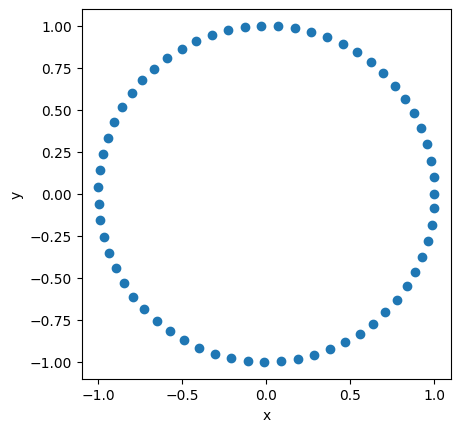

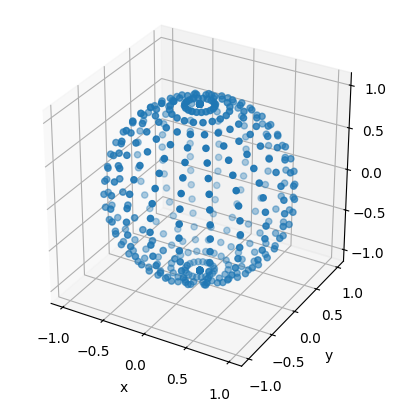

In [4]:
# Run code for data x2D and x3D
fig2D, ax_2D = plt.subplots()
fig3D = plt.figure()
ax_3D = fig3D.add_subplot(projection='3d')
res2D = pflat(x2D)
res3D = pflat(x3D)
plotter.plot_points_2D(ax_2D, res2D)
plotter.plot_points_3D(ax_3D, res3D)
plt.show()

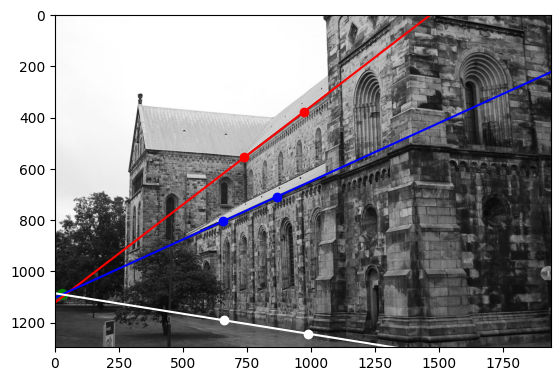

8.26949135625704


In [5]:
# Computer Exercise 2
fig, ax = plt.subplots()

# Get image size
img_height, img_width, _ = compEx2.shape

# Plot image (have to explicitly tell matplotlib it's grayscale)
if len(compEx2.shape) == 2: 
    ax.imshow(compEx2, cmap='gray')
else: 
    ax.imshow(compEx2)

# Plot points
ax.scatter(p1[0], p1[1], c='r')
ax.scatter(p2[0], p2[1], c='b')
ax.scatter(p3[0], p3[1], c='w')

# Set boundaries and invert y-axis to match image coordinates
ax.set_xlim(0, img_width)
ax.set_ylim(img_height, 0)

# Compute line connecting each pair of dot
# The line is found as the cross product of two dots in homogeneous coordinates
def inter_line(point1, point2):
    line = np.cross(point1, point2)
    return line/line[-1]

l1 = inter_line(p1[:,0], p1[:,1])
l2 = inter_line(p2[:,0], p2[:,1])
l3 = inter_line(p3[:,0], p3[:,1])

# Plot lines
x_vals = np.linspace(0, img_width, 100)

y_1 = -(l1[0] * x_vals + l1[2]) / l1[1]
y_2 = -(l2[0] * x_vals + l2[2]) / l2[1]
y_3 = -(l3[0] * x_vals + l3[2]) / l3[1]

ax.plot(x_vals, y_1, c='r')
ax.plot(x_vals, y_2, c='b')
ax.plot(x_vals, y_3, c='w')


# The point of intersection between l2 and l3 is the cross product
p_intersect = np.cross(l2, l3)
p_intersect /= p_intersect[-1]
ax.scatter(p_intersect[0], p_intersect[1], c='g', s=50)

plt.show()

def point_line_distance2D(point: np.ndarray, line: np.ndarray) -> np.ndarray:
    ''' Return the distance between a line and a point in 2D cartesian coordinates.

    Parameters
    ----------
    point: np.ndarray
        A 2D point in R2 or P2 (must be normalized for P2)

    line: np.ndarray
        A line on the shape (a, b, c)

    Returns
    -------
        The distance between the point and line

    '''
    a, b, c = line
    x1, x2 = point[0:2]
    return abs(a*x1 + b*x2 + c) / math.sqrt(a**2 + b**2)

# Compute the distance between l1 and intersect point of l2 and l3
d_intersect = point_line_distance2D(p_intersect, l1)
print(d_intersect)

# The distance is 8 which is not close to , hinting that line 1 is not exactly parallel to l2 and l3,
# or that some distortion exists


--- P1 ---
 center:
 [[0.]
 [0.]
 [0.]] 
principal axis:
 [0.31 0.95 0.08]
--- P2 ---
 center:
 [[  6.64]
 [ 14.85]
 [-15.07]] 
principal axis:
 [0.03 0.34 0.94]


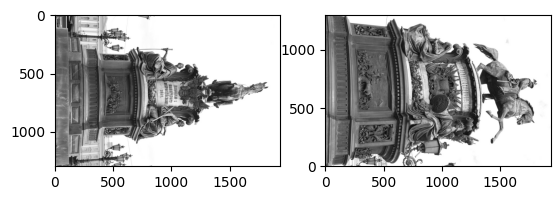

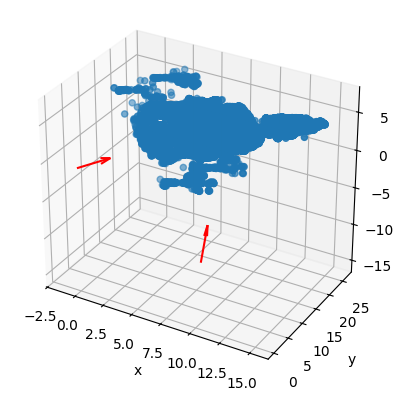

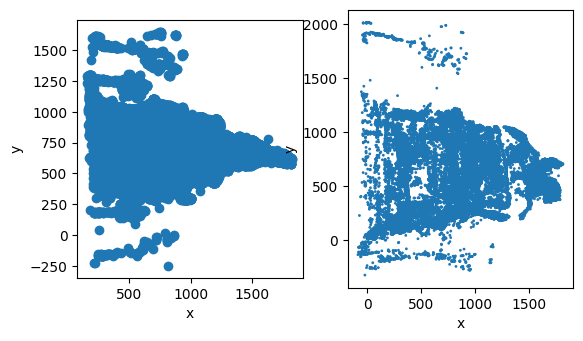

In [6]:
# Computer Exercise 3
def camera_center_and_axis(P: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''' Get camera center and principle axis of the camera matrix 'P'

    Parameters
    ----------
    P: np.ndarray
        The camera matrix
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray] 
        The first array is the camera center in cartesian coordinates
        The second array is the principal axis normalized to length 1
        
    '''
    # The camera center is the null space of the camera matrix
    camera_center = null_space(P)
    # The principal axis is the third row of R
    camera_center_cart = (camera_center / camera_center[-1])[0:-1]
    principal_axis = P[2,0:3]
    principal_axis_norm = principal_axis / np.linalg.norm(principal_axis)

    return (camera_center_cart, principal_axis_norm)
    

def plot_camera(ax: plt.axes, P: np.ndarray, scale: float) -> None:
    ''' Plots the principal axis of a camera scaled by s

    Internally calls on 'camera_center_and_matrix' to get the
    center and principal axis of the camera.

    Parameters
    ----------
    ax: plt.axes
        The matplotlib surface to plot on (from fig, ax = plt.subplots())

    P: np.ndarray
        The camera matrix
    
    scale: float
        The length (scale) of the camera principal axis    
    
    '''
    center, axis = camera_center_and_axis(P)
    axis = axis
    ax.quiver(center[0], center[1], center[2], axis[0], axis[1], axis[2], length=scale, arrow_length_ratio=0.3, color='r')

# Get camera center and principal axis for the two cameras
P1_center, P1_axis = camera_center_and_axis(P1)
P2_center, P2_axis = camera_center_and_axis(P2)
print("--- P1 ---\n center:\n", P1_center.round(2), "\nprincipal axis:\n", P1_axis.round(2))
print("--- P2 ---\n center:\n", P2_center.round(2), "\nprincipal axis:\n", P2_axis.round(2))

# Plot the two images
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(compEx3im1)
ax2.imshow(compEx3im2)
ax1.set_xlim(0, compEx3im1.shape[1])
ax1.set_ylim(compEx3im1.shape[0], 0)
ax2.set_xlim(0, compEx3im2.shape[1])
ax2.set_ylim(0, compEx3im2.shape[0])
plt.show()

fig = plt.figure()
ax_3D = fig.add_subplot(111, projection='3d')

# Plot cameras and the points U
plotter.plot_points_3D(ax_3D, pflat(U))
plot_camera(ax_3D, P1, 5)
plot_camera(ax_3D, P2, 5)

# Project U onto P1 and P2
U_P1 = np.matmul(P1, pflat(U))
U_P1 = pflat(U_P1)
U_P2 = np.matmul(P2, pflat(U))
U_P2 = pflat(U_P2)

fig_2D, axs_2D = plt.subplots(1, 2)
plotter.plot_points_2D(axs_2D[0], U_P1)
plotter.plot_points_3D(axs_2D[1], U_P2)

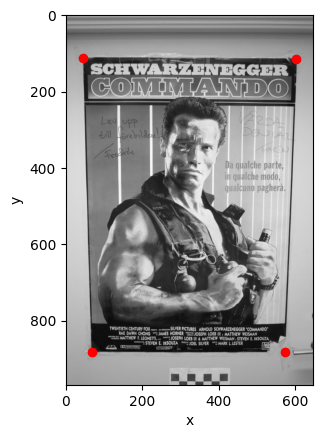

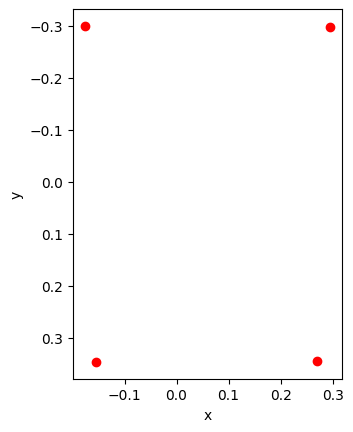

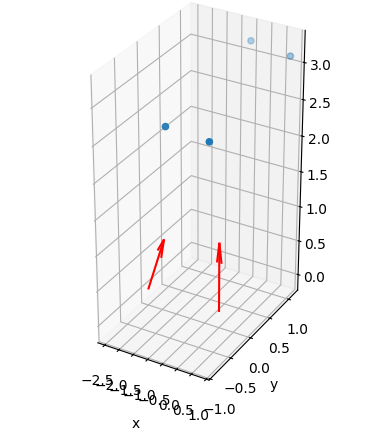

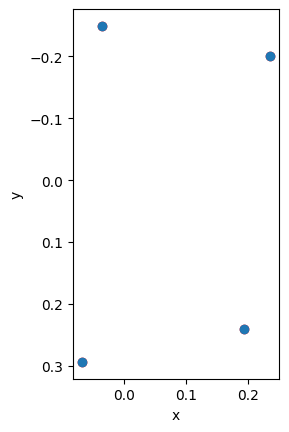

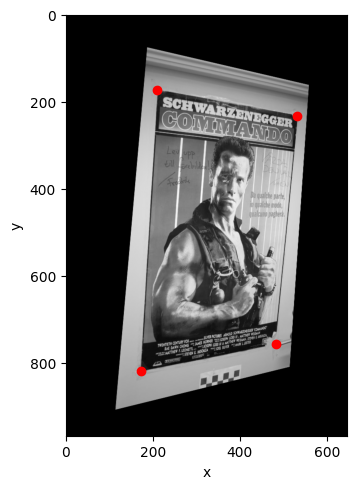

In [7]:
# Computer Exercise 4
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Show image
ax.imshow(compEx4)
# Plot points
plotter.plot_points_2D(ax, corners, c='r')

plt.show()

### Answer to question: The origin is in the upper left corner

# Calibrate camera
K_inv = inv(K)
corners_norm = np.matmul(K_inv, corners)

# Plot normalized corners
fig, ax = plt.subplots()
ax.set_aspect('equal')
plotter.plot_points_2D(ax, corners_norm, c='r')
ax.invert_yaxis()
plt.show()

### Answer to question: The origin of the image coordinate system is 
### now located slightly to the left of the middle of the image.

# The corners in 3D is given by finding s so that U = (x s) is orthogonal to plane
v_norm = pflat(v)
corners_3D = np.array([c / -np.matmul(v_norm.T[:,:-1], c) for c in corners_norm.T]).T
corners_3D_hom = np.vstack([corners_3D, np.ones((1, corners_3D.shape[1]))])

# Get camera center and principal axis. P is now [I 0] after calibration
P = np.array(np.hstack([np.identity(3), np.zeros((3, 1))]))
center, axis = camera_center_and_axis(P)

# Plot Camera and 3D corners
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(111, projection='3d')
plot_camera(ax_3D, P, 1)
plotter.plot_points_3D(ax_3D, corners_3D_hom)
ax_3D.set_aspect('equal')

### Answer to question: Yes, the 3D points look reasonable compared to their 2D projection.

# Compute new Camera P2
R = np.array([
    [np.cos(np.pi/5), 0, -np.sin(np.pi/5)],
    [0              , 1,                0],
    [np.sin(np.pi/5), 0,  np.cos(np.pi/5)]
])
C_P2 = np.array([-2.5, 0, 0])
# t is given by solving 0 = RC + t <=> t = -RC
t = -np.matmul(R, C_P2).reshape(3, 1)
P2 = np.hstack([R, t])

# Plot new camera
plot_camera(ax_3D, P2, 1)

# Transform the normalized corner points to using the homography H = (R - t*v_norm^T)
H = (R - np.matmul(t, v_norm[:-1].T))
corners_new = np.array([np.matmul(H, c) for c in corners_norm.T]).T
corners_new_norm = pflat(corners_new)

# Plot transformed points
fig, ax = plt.subplots()
ax.invert_yaxis()
plotter.plot_points_2D(ax, corners_new_norm, c='r')

# Project 3D points onto P2
corners_proj_P2 = np.matmul(P2, corners_3D_hom)
corners_proj_P2_norm = corners_proj_P2 / corners_proj_P2[-1]

# Plot projected points in P2
plotter.plot_points_2D(ax, corners_proj_P2_norm[:2,:])

### Answer to question: Yes! The transformed and projected points are located at the same positions

# Create total homography H_tot = K H K_inv
H_tot = np.matmul(K, np.matmul(H, K_inv))

# Transform image and original corner points to new image
tForm = transform.ProjectiveTransform(H_tot)
compEx4_transformed = transform.warp(compEx4, tForm.inverse)
corners_transformed = np.matmul(H_tot, corners)
corners_transformed_norm = pflat(corners_transformed)

# Plot transformation
fig_transform, ax_transform = plt.subplots()

ax_transform.imshow(compEx4_transformed)
fig_transform.tight_layout()
ax_transform.set_aspect('equal')
plotter.plot_points_2D(ax_transform, corners_transformed_norm, c='r')

### Show everything
plt.show()
